In [1]:
import numpy as np
# hide numpy log warning
import glob
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from tqdm.notebook import tqdm

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)
from statannotations.Annotator import Annotator
from sklearn.model_selection import LeaveOneGroupOut
from scipy.stats import wilcoxon

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
%matplotlib inline

## Data and functions

In [2]:
# import all splits
metadata = pd.read_csv('../../data/case-studies/decomposer/machine-learning/splits_metadata.csv', index_col=0)
all_ordinations = {(ord_fp.split('/')[-1].split('.')[0],
                    ord_fp.split('/')[-1].split('.')[1]):OrdinationResults.read(ord_fp)
                   for ord_fp in glob.glob('../../data/case-studies/decomposer/machine-learning/ordinations/*')}


In [3]:
def rf_regression(ord_all, shared_mt, cat_of_interest,
                  n_estimators=500, random_state=999,
                  optimize=False, param_grid=None, 
                  criterion="mae", bootstrap=True, 
                  cv_scoring='neg_mean_absolute_error', 
                  **kwargs):

    criterion_all = {}
    
    #iterate over ord_ination tables
    for (omic, fold), ord_ in tqdm(ord_all.items()):
        
        # make sure we only use _within_ location regression
        X = ord_.samples.copy()
        shared_mt_subset_tmp_ = shared_mt.loc[X.index, :].copy()
        shared_mt_subset_tmp_ = shared_mt_subset_tmp_[shared_mt_subset_tmp_.facility == shared_mt_subset_tmp_[shared_mt_subset_tmp_[fold] == 'train'].facility[0]]
        X = X.loc[shared_mt_subset_tmp_.index, :]
        groups = shared_mt_subset_tmp_.loc[X.index, 'subjects']
        y = X.index.map(shared_mt_subset_tmp_[cat_of_interest])
        y = y.astype(float)
        #split data into pre-defined train and test sets
        X_group = X.index.map(shared_mt[fold])
        train_index = [True if x == 'train' else False for x in X_group]
        test_index = [True if x == 'test' else False for x in X_group]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if optimize:
            #initialize random forest
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       random_state=random_state,
                                       criterion=criterion, **kwargs)
            # leave-one-body-out for hyperparamter tuning
            inner_cv = LeaveOneGroupOut().split(X[train_index], y[train_index],
                                                groups=groups[train_index])
            grid_search = GridSearchCV(estimator=rf, 
                                       param_grid=param_grid, 
                                       cv=inner_cv, 
                                       n_jobs=-1, verbose=0, 
                                       scoring=cv_scoring)
            grid_search.fit(X_train.values, y_train)
            #save best parameters
            best_params = grid_search.best_params_.copy()
            best_params['best_score'] = grid_search.best_score_
            #get best model
            best_rf = grid_search.best_estimator_

        else:
            #initialize random forest with user-defined parameters
            rf = RandomForestRegressor(n_estimators=n_estimators, 
                                       bootstrap=bootstrap,
                                       random_state=random_state, 
                                       criterion=criterion, **kwargs)
            rf.fit(X_train.values, y_train)
            best_params = 'None'
            best_rf = rf

        #predict on test set
        y_pred = best_rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        #save results for each fold
        criterion_all[(omic, fold)] = (mse, mae, best_params)
        
    #save results for each omic
    #criterion_ord_[omic] = criterion_fold

    #initialize dataframes to store results
    criterion_metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'MSE', 
                                                 'MAE', 'Optimization'])
    
    #create df with metrics
    for (omic, fold), metrics in criterion_all.items():
    #for omic, criterion_fold in criterion_ord_.items():
    #for fold, metrics in criterion_fold.items():
        criterion_metrics_df = criterion_metrics_df._append(
            {'Omic': omic, 'Fold': fold, 
             'MSE': metrics[0], 'MAE': metrics[1],
             'Optimization': metrics[2]}, ignore_index=True)

    return criterion_metrics_df


## Ordination-based regression

### RF with default parameters

In [5]:
#add 0c with criterion = squared_error (MSE)
param_grid = {"max_depth": [None, 4],
              "max_features": ['auto', 0.2],
              "bootstrap": [True, False]}
rf_reg_add = rf_regression(all_ordinations,  
                           shared_mt=metadata, 
                           cat_of_interest='add_0c', 
                           criterion="absolute_error", 
                           optimize=False,
                           param_grid=param_grid
                          )
display(rf_reg_add.head())


  0%|          | 0/138 [00:00<?, ?it/s]

,Omic,Fold,MSE,MAE,Optimization
0,18S,traintest_9,18731.806034,112.675204,None
1,joint,traintest_2,9689.189625,76.783849,None
2,metabolomics,traintest_1,31334.878414,145.372844,None
3,gene_module,traintest_2,9240.660508,77.819909,None
4,mag,traintest_13,15923.860889,106.439506,None


In [6]:
rename_ = {'18S':'18S_RPCA',
           'gene_module':'Gene_Module_RPCA',
           'joint':'Joint_RPCA',
           'mag':'MAG_RPCA',
           'metabolite':'Metabolite_RPCA',
           'metabolomics':'Metabolomics_RPCA'}

rf_reg_add['Omic'] = rf_reg_add.Omic.replace(rename_)
rf_reg_add.head(5)

,Omic,Fold,MSE,MAE,Optimization
0,18S_RPCA,traintest_9,18731.806034,112.675204,None
1,Joint_RPCA,traintest_2,9689.189625,76.783849,None
2,Metabolomics_RPCA,traintest_1,31334.878414,145.372844,None
3,Gene_Module_RPCA,traintest_2,9240.660508,77.819909,None
4,MAG_RPCA,traintest_13,15923.860889,106.439506,None


In [7]:
order = ['18S_RPCA', 'MAG_RPCA', 
         'Gene_Module_RPCA', 'Metabolomics_RPCA',
         'Metabolite_RPCA', 'Joint_RPCA']

# subset to show
order = ['MAG_RPCA',
         '18S_RPCA', 
         'Gene_Module_RPCA',
         'Metabolomics_RPCA',
         'Joint_RPCA']
rf_reg_add_subset = rf_reg_add[rf_reg_add.Omic.isin(order)]
rf_reg_add_subset.to_csv('../../data/case-studies/decomposer/machine-learning/RF-MAE-scores.csv')
rf_reg_add_subset.head(5)

,Omic,Fold,MSE,MAE,Optimization
0,18S_RPCA,traintest_9,18731.806034,112.675204,None
1,Joint_RPCA,traintest_2,9689.189625,76.783849,None
2,Metabolomics_RPCA,traintest_1,31334.878414,145.372844,None
3,Gene_Module_RPCA,traintest_2,9240.660508,77.819909,None
4,MAG_RPCA,traintest_13,15923.860889,106.439506,None


In [8]:
#load results
# rf_reg_add_subset = pd.read_csv('../../data/case-studies/decomposer/machine-learning/RF-MAE-scores.csv', index_col=0)
# rf_reg_add_subset.head(5)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolomics_RPCA vs. Joint_RPCA: P=0.0007
Gene_Module_RPCA vs. Joint_RPCA: P=0.0045
18S_RPCA vs. Joint_RPCA: P=0.0302
MAG_RPCA vs. Joint_RPCA: P=0.0325


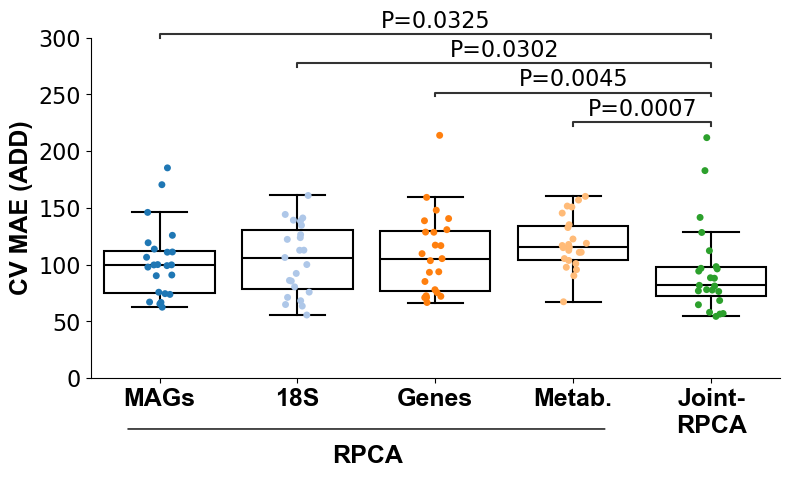

In [10]:
#focus on active vs all task
order = ['MAG_RPCA', '18S_RPCA', 'Gene_Module_RPCA', 
         'Metabolomics_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order if omic != "Joint_RPCA"]
plotting_params = {'x':'Omic', 
                   'data': rf_reg_add_subset, 'order':order}

boxPROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
plotting_params['y'] = 'MAE'
sns.boxplot(ax=ax,  **{**plotting_params, **boxPROPS}, showfliers=False)
sns.stripplot(ax=ax, **plotting_params, palette='tab20')

#add statistical test
annotator = Annotator(ax, stat_pairs, **plotting_params)
less_compare = rf_reg_add_subset[rf_reg_add_subset.Omic == order[-1]].set_index('Fold')
y_ = less_compare['MAE'].values
stats_all = {}
for omic_ in order[:-1]:
    tmp_compare = rf_reg_add_subset[rf_reg_add_subset.Omic == omic_].set_index('Fold')
    tmp_compare = tmp_compare.reindex(less_compare.index)
    x_ = tmp_compare['MAE'].values
    t_, p_ = wilcoxon(y_, x_, alternative='less')
    stats_all[omic_] = {'test_stat':t_, 'p':p_}
stats_all = pd.DataFrame(stats_all).T 
annot_ = []
for p_ in stats_all.p:
    if 'e' in str(p_):
        p_ = str(p_)
        p_ = p_[:4] + p_[p_.index('e'):]
        annot_.append("P=%s" %p_)
    else:
        p_ = str(p_)[:6]
        annot_.append("P=%s" %p_)

annotator.configure(fontsize=16)
annotator.annotate_custom_annotations(annot_)

"""
Style
"""
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['left'].set_bounds(0, 300)
ax.set_ylim(0, 300)

for tick in ax.get_yticklabels():
    tick.set_weight('normal')
    tick.set_color("black")
    tick.set_fontsize(16)
fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0)
ax.set_facecolor('white')
ax.patch.set_alpha(0)
ax.set_xticklabels([x.get_text().replace('_RPCA','').replace('Joint','Joint-\nRPCA').replace('Gene_Module','Genes').replace('MAG','MAGs').replace('Metabolomics','Metab.')  
                    for x in ax.get_xticklabels()])
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)

ax.set_xlabel('')
ax.set_ylabel('CV MAE (ADD)', fontsize=18, 
              color='black', weight='bold', fontname='Arial')
ax.set_title('')

add_ = 0
ax.annotate('', xy=(0.05, -0.15 - add_), 
            xycoords='axes fraction', xytext=(0.75, -0.15 - add_),
arrowprops=dict(arrowstyle="-", color='black'))

ax.annotate('RPCA', xy=(0.35, -0.25 - add_), 
            xycoords='axes fraction', xytext=(0.35, -0.25 - add_), 
            fontsize=18, weight='bold', fontname='Arial')

plt.tight_layout()

plt.savefig('../../results/figure-5B.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-5B.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()